In [3]:
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
%matplotlib inline
from pandas.plotting import scatter_matrix
import seaborn as sns
import plotly.express as px
from pandas.plotting import parallel_coordinates

import scipy.stats as stats
from scipy.stats import yeojohnson

from prince import MCA

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_curve, auc as pr_auc, PrecisionRecallDisplay, roc_curve, roc_auc_score, f1_score, precision_score, recall_score, matthews_corrcoef

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import optuna

import lime
from lime.lime_tabular import LimeTabularExplainer
import shap 

import pymc as pm

In [2]:
df = pd.read_csv("dataset/fraud_detection_data.csv")

In [4]:
df.head()

step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [6]:
# No nulls to handle but dtype 'object' requires handling

In [7]:
df = df[:4000] # For computational ease to significantly reduce df size 

In [8]:
round(df["isFraud"].value_counts()/df.shape[0]*100,2) # Check that dataset reduction has maintained some the minority class

isFraud
0    99.4
1     0.6
Name: count, dtype: float64

In [9]:
obj_cols = df.select_dtypes(include="object")
df[obj_cols.columns] = obj_cols.astype("string")

In [10]:
df.describe()

step        amount  oldbalanceOrg  newbalanceOrig  \
count  4000.000000  4.000000e+03   4.000000e+03    4.000000e+03   
mean      1.392500  9.728446e+04   9.757329e+05    9.986357e+05   
std       0.614441  2.249773e+05   2.178887e+06    2.226924e+06   
min       1.000000  6.420000e+00   0.000000e+00    0.000000e+00   
25%       1.000000  3.980838e+03   4.570000e+02    0.000000e+00   
50%       1.000000  1.069476e+04   2.568190e+04    1.721129e+04   
75%       2.000000  1.080544e+05   2.700913e+05    2.685557e+05   
max       3.000000  3.776389e+06   1.222588e+07    1.245865e+07   

       oldbalanceDest  newbalanceDest      isFraud  isFlaggedFraud  
count    4.000000e+03    4.000000e+03  4000.000000          4000.0  
mean     8.040874e+05    9.726647e+05     0.006000             0.0  
std      2.327466e+06    2.793190e+06     0.077237             0.0  
min      0.000000e+00    0.000000e+00     0.000000             0.0  
25%      0.000000e+00    0.000000e+00     0.000000             0.0  
50%      0.000000e+00    0.000000e+00     0.000000             0.0  
75%      3.549717e+05    2.679668e+05     0.000000             0.0  
max      1.951612e+07    1.916920e+07     1.000000             0.0

In [11]:
df = df.drop("isFlaggedFraud", axis=1)

In [12]:
##########################

In [13]:
## Data Encoding

In [14]:
# For reference as encode:

df.head()

step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  
0  M1979787155             0.0             0.0        0  
1  M2044282225             0.0             0.0        0  
2   C553264065             0.0             0.0        1  
3    C38997010         21182.0             0.0        1  
4  M1230701703             0.0             0.0        0

In [15]:
df["type"].value_counts()

type
PAYMENT     2077
CASH_IN      818
CASH_OUT     513
TRANSFER     360
DEBIT        232
Name: count, dtype: Int64

In [16]:
# No ordinality observed so to one-hot encode 'type' feature
df_encoded = pd.get_dummies(df, columns=["type"])

In [17]:
# Check 'nameOrig' to determine uniquness

df_encoded["nameOrig"].is_unique

True

In [18]:
# Check whether there's any 'nameOrig' entries that don't involve numbers prefixed with a 'C' followed by a number 
# between 1-9 (ensures that if 'C' is dropped then won't lose any leading zeroes as dtype int) and then the rest numbers

df_encoded[
    ~df_encoded["nameOrig"].str.contains("^C[1-9][0-9]*$", regex=True)
]  

Empty DataFrame
Columns: [step, amount, nameOrig, oldbalanceOrg, newbalanceOrig, nameDest, oldbalanceDest, newbalanceDest, isFraud, type_CASH_IN, type_CASH_OUT, type_DEBIT, type_PAYMENT, type_TRANSFER]
Index: []

In [19]:
# Remove 'C' prefix

df_encoded["nameOrig"] = df_encoded["nameOrig"].str.replace("C", "").astype("int")

In [20]:
# As with 'nameOrig', check 'nameDest' for any entries not conforming to observed pattern and for any leading zeroes after letter

df_encoded[
    ~df_encoded["nameDest"].str.contains("^[MC][1-9][0-9]*$", regex=True)
]

Empty DataFrame
Columns: [step, amount, nameOrig, oldbalanceOrg, newbalanceOrig, nameDest, oldbalanceDest, newbalanceDest, isFraud, type_CASH_IN, type_CASH_OUT, type_DEBIT, type_PAYMENT, type_TRANSFER]
Index: []

In [21]:
# Remove prefixes and one-hot encode information as no ordinality present

df_encoded["nameDestLabel"] = df_encoded["nameDest"].str[0]
df_encoded = pd.get_dummies(df_encoded, columns=["nameDestLabel"])
df_encoded["nameDest"] = df_encoded["nameDest"].str.replace("[MC]", "", regex=True).astype("int")

In [22]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   step             4000 non-null   int64  
 1   amount           4000 non-null   float64
 2   nameOrig         4000 non-null   int32  
 3   oldbalanceOrg    4000 non-null   float64
 4   newbalanceOrig   4000 non-null   float64
 5   nameDest         4000 non-null   int32  
 6   oldbalanceDest   4000 non-null   float64
 7   newbalanceDest   4000 non-null   float64
 8   isFraud          4000 non-null   int64  
 9   type_CASH_IN     4000 non-null   bool   
 10  type_CASH_OUT    4000 non-null   bool   
 11  type_DEBIT       4000 non-null   bool   
 12  type_PAYMENT     4000 non-null   bool   
 13  type_TRANSFER    4000 non-null   bool   
 14  nameDestLabel_C  4000 non-null   bool   
 15  nameDestLabel_M  4000 non-null   bool   
dtypes: bool(7), float64(5), int32(2), int64(2)
memory usage: 277

In [23]:
##########################

In [24]:
### EDA

In [25]:
## Univariate Analysis

In [26]:
# Select continuous variables
continuous_cols = df_encoded.select_dtypes(include=["int", "float"]).iloc[:,1:-1]


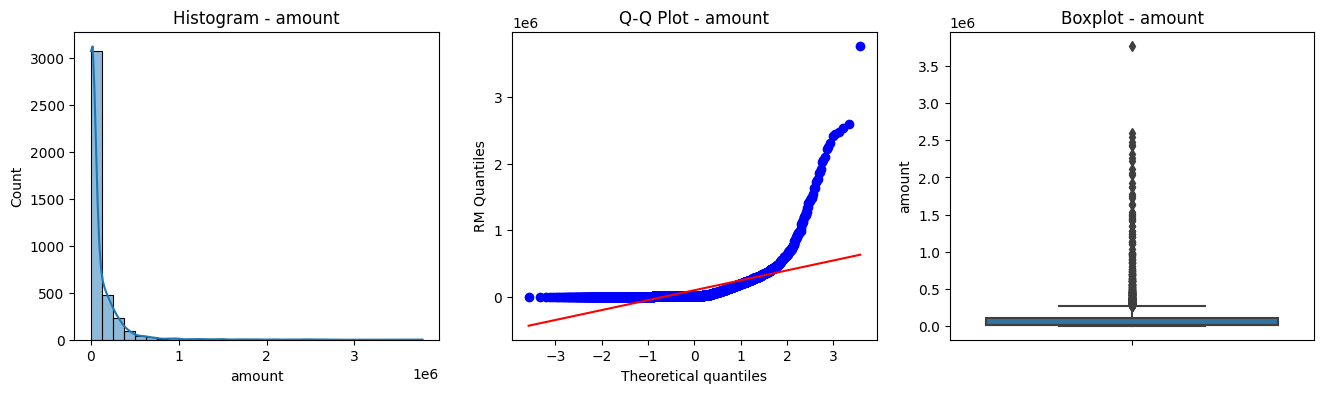

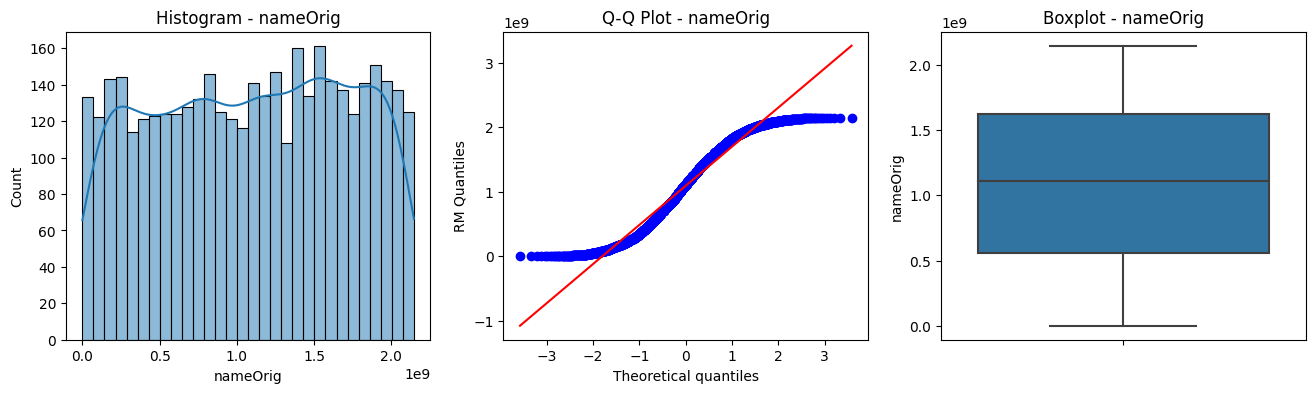

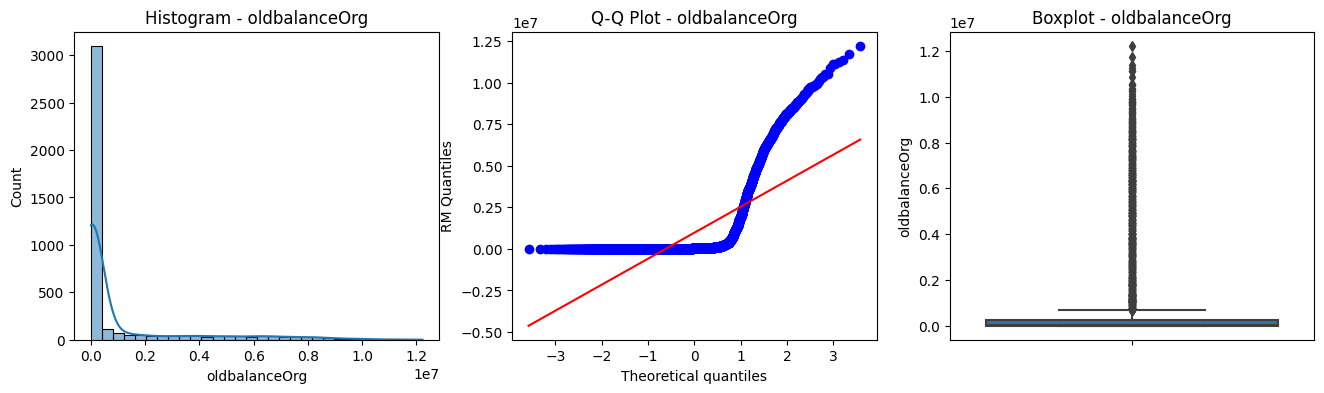

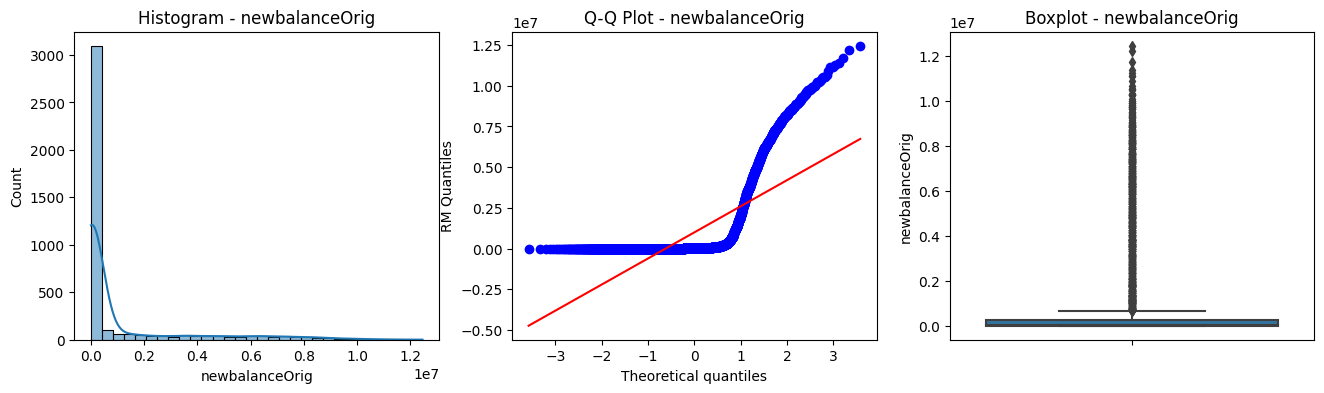

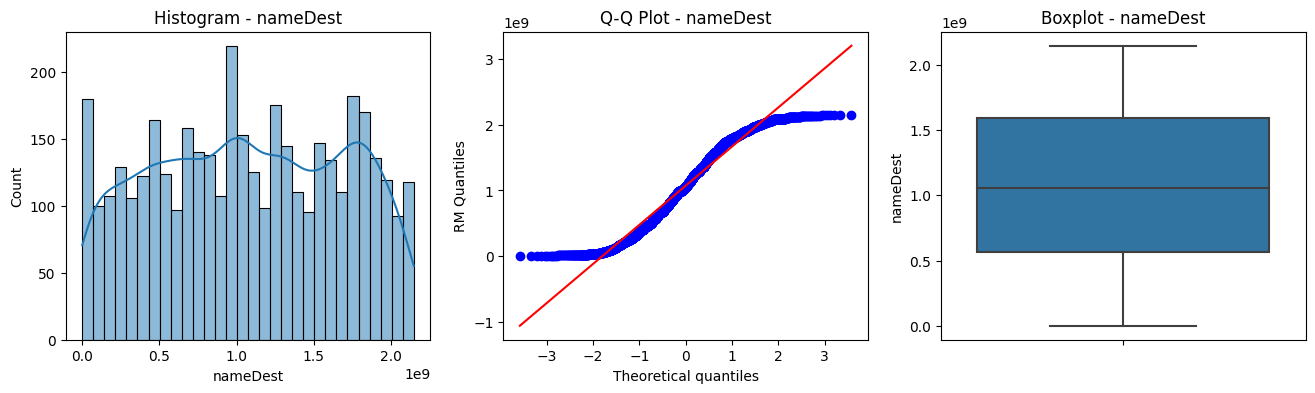

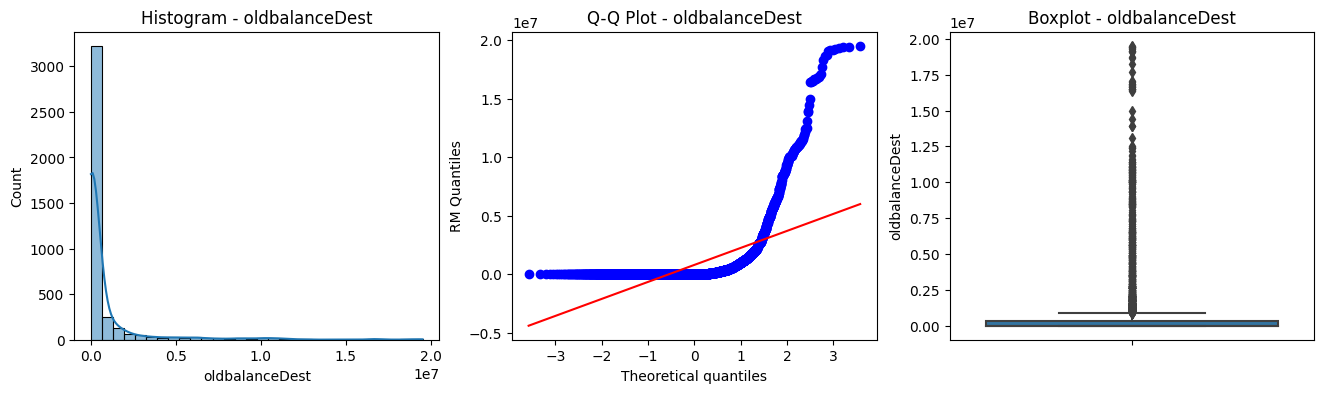

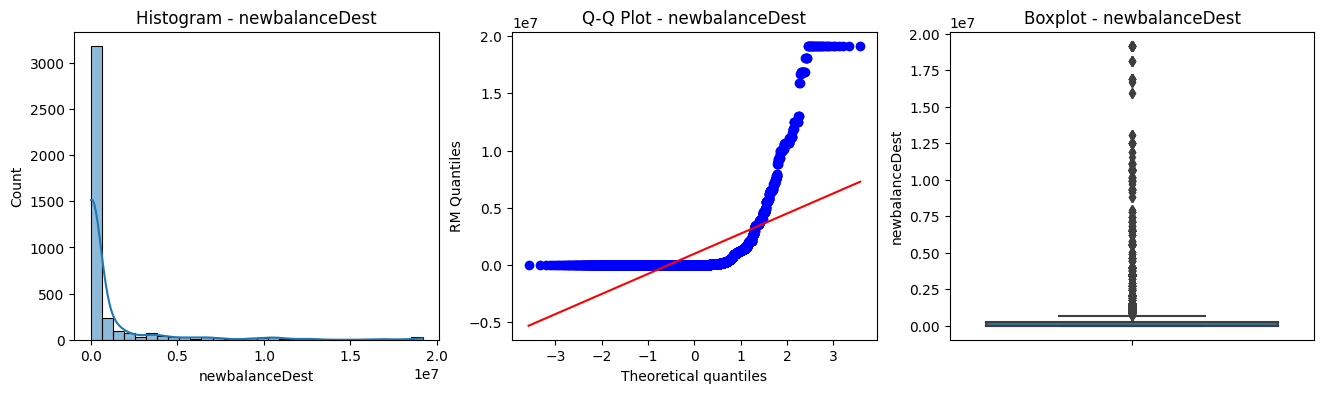

In [27]:
# Run diagnostic plots to explore distributions and check for outliers

def diagnostic_plots(dataframe, variable):
    plt.figure(figsize=(16, 4))

    plt.subplot(1, 3, 1)
    sns.histplot(dataframe[variable], bins=30, kde=True)
    plt.title(f"Histogram - {variable}")

    plt.subplot(1, 3, 2)
    stats.probplot(dataframe[variable], dist="norm", plot=plt)
    plt.ylabel("RM Quantiles")
    plt.title(f"Q-Q Plot - {variable}")

    plt.subplot(1, 3, 3)
    sns.boxplot(y=dataframe[variable])
    plt.title(f"Boxplot - {variable}")

    plt.show()


for col in continuous_cols.columns:
    diagnostic_plots(df_encoded, col)

In [28]:
# Extreme right skew shown for the continuous variables, bar 'nameDest'and 'nameOrig'.
# To attempt Yeo-Johnson transformation to address skew

In [29]:
skewed_cols = ["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]

transformed_df = df_encoded.copy()

for col in skewed_cols:
    transformed_df[col], _ = yeojohnson(transformed_df[col])

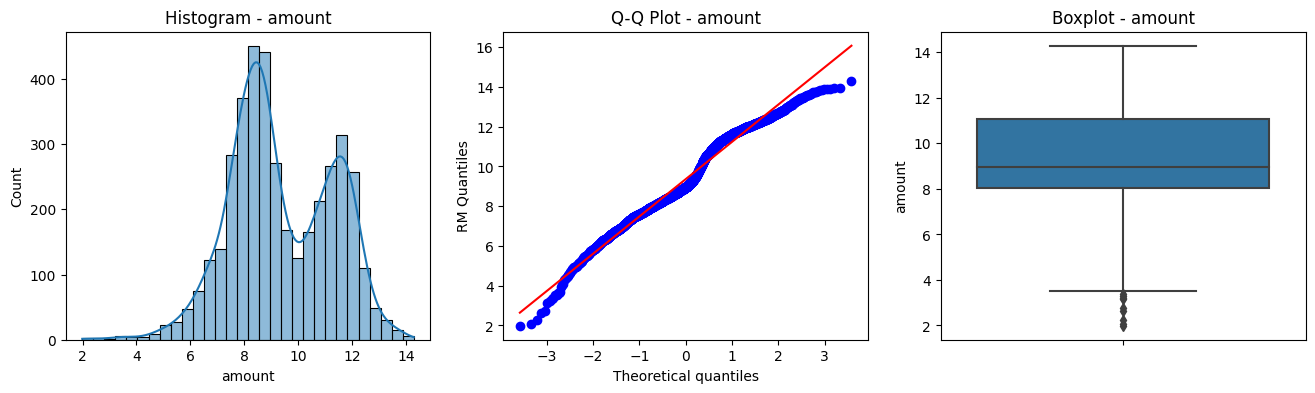

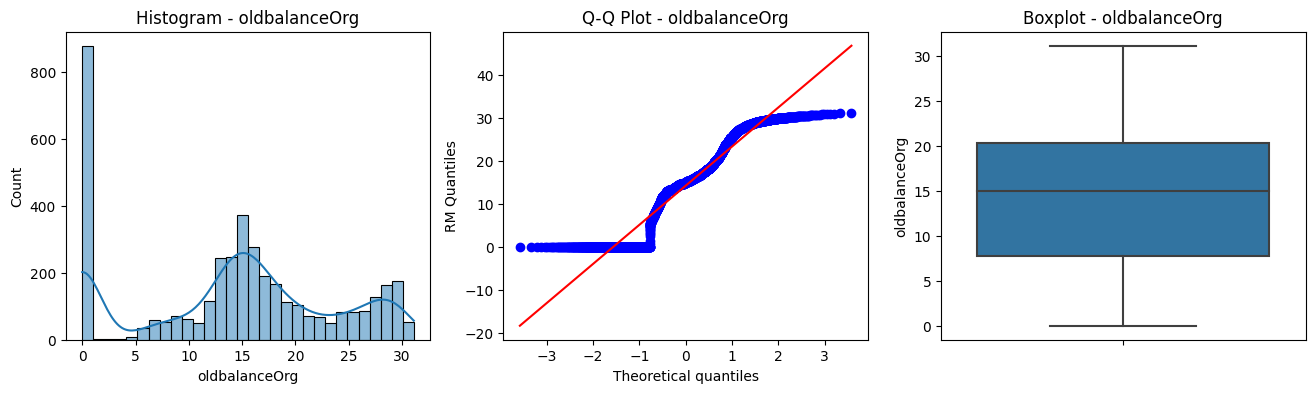

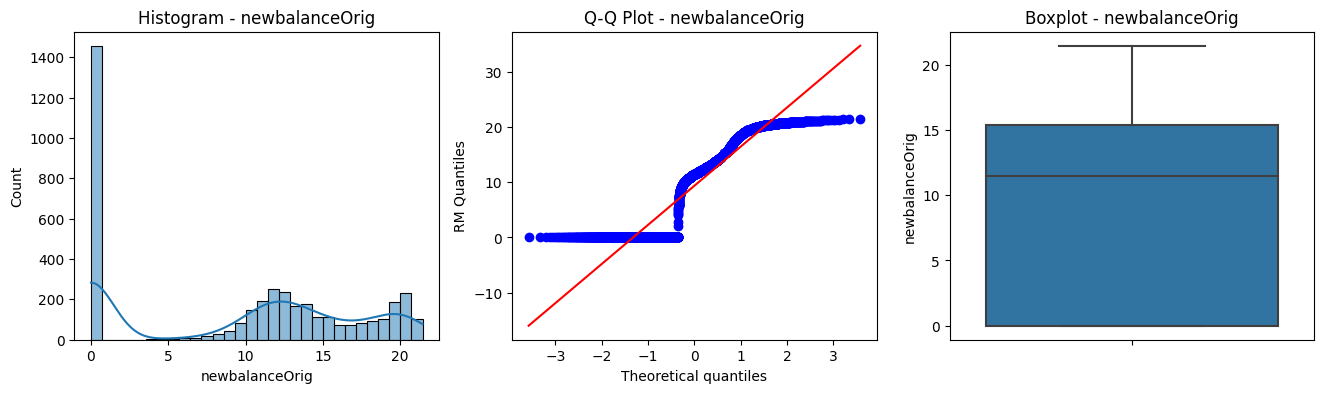

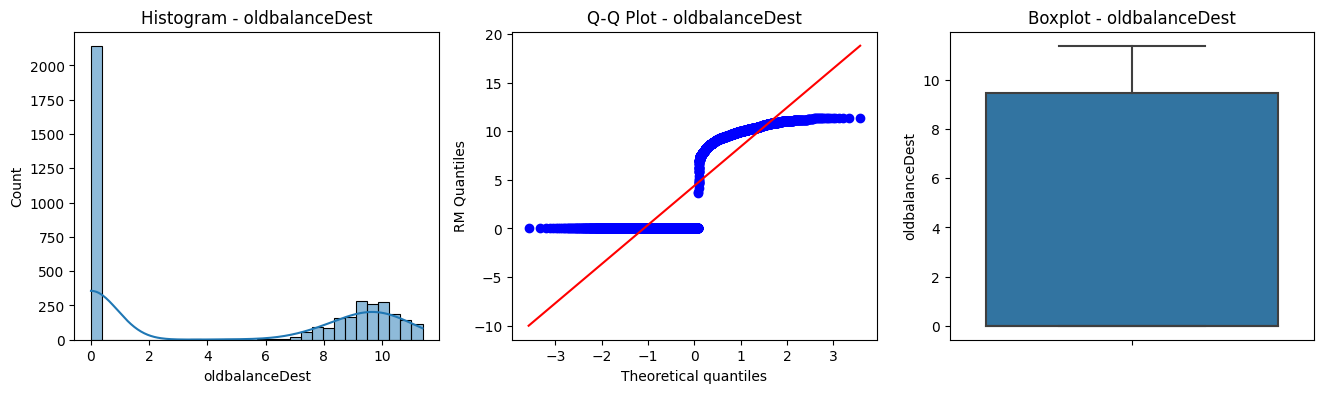

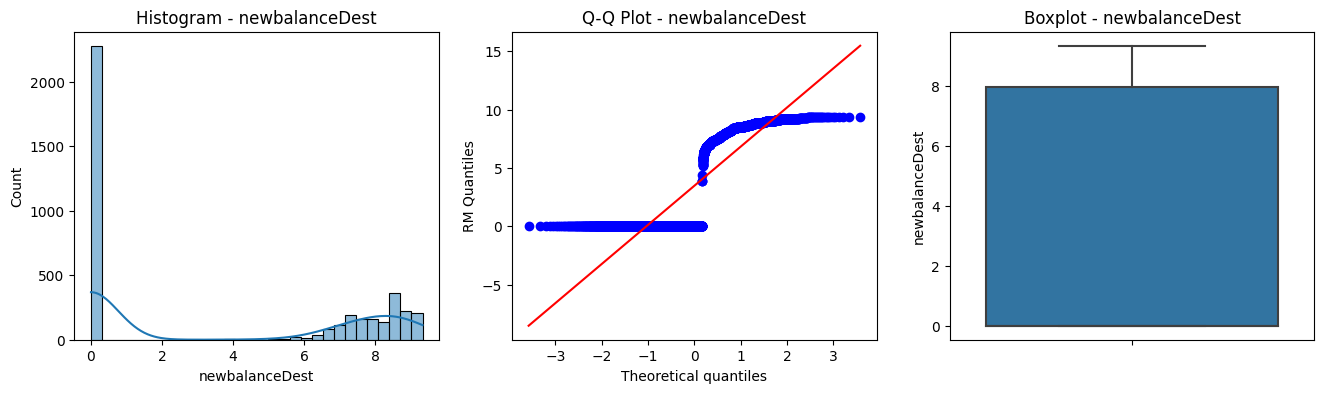

In [30]:
# Re-run diagnostics plots on selected columns:

for col in transformed_df[skewed_cols].columns:
    diagnostic_plots(transformed_df, col)

In [31]:
# 'newbalanceOrig' and 'oldbalanceOrg' and, especially, 'amount' demonstrate clear biphasic natures, suggestive of multi-modal structure.
# Other variables problematic due to being zero-inflated, but still clear Gaussian-esque distributions after power transformation. 
# To investigate the possibility of sub-groupings/clusters in certain features after EDA completion with clustering algorithms.

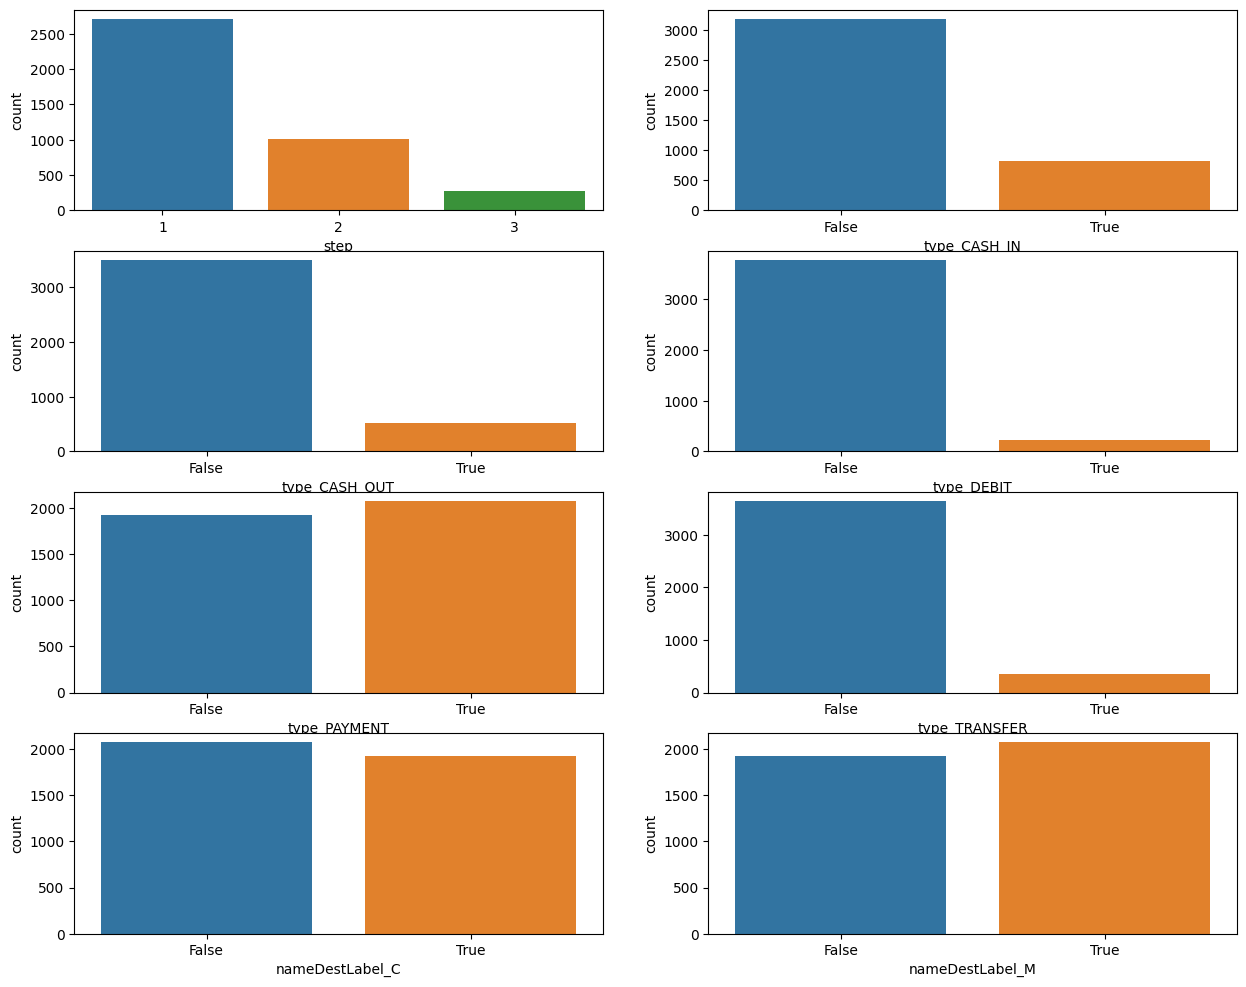

In [32]:
discrete_cols = pd.concat([transformed_df["step"], transformed_df.select_dtypes(include="bool")], axis=1).columns
n = len(discrete_cols)

fig, ax = plt.subplots(math.ceil(n/2), 2, figsize=(15,12), sharey=False)
axes = ax.flatten()

for i in range(n):
    sns.countplot(data=transformed_df, x=discrete_cols[i], ax=axes[i])


In [33]:
# Payment types: Reasonably balanced binary account of type_PAYMENT whereas other false dominates other payment types indicating the predominance of type_PAYMENT 
# Payment destination: Reasonably balanced amounts of customers and merchants as
# Step size: Inverse correlation with transaction length (in hours) and number of transactions.

In [34]:
## Bi-variate analysis

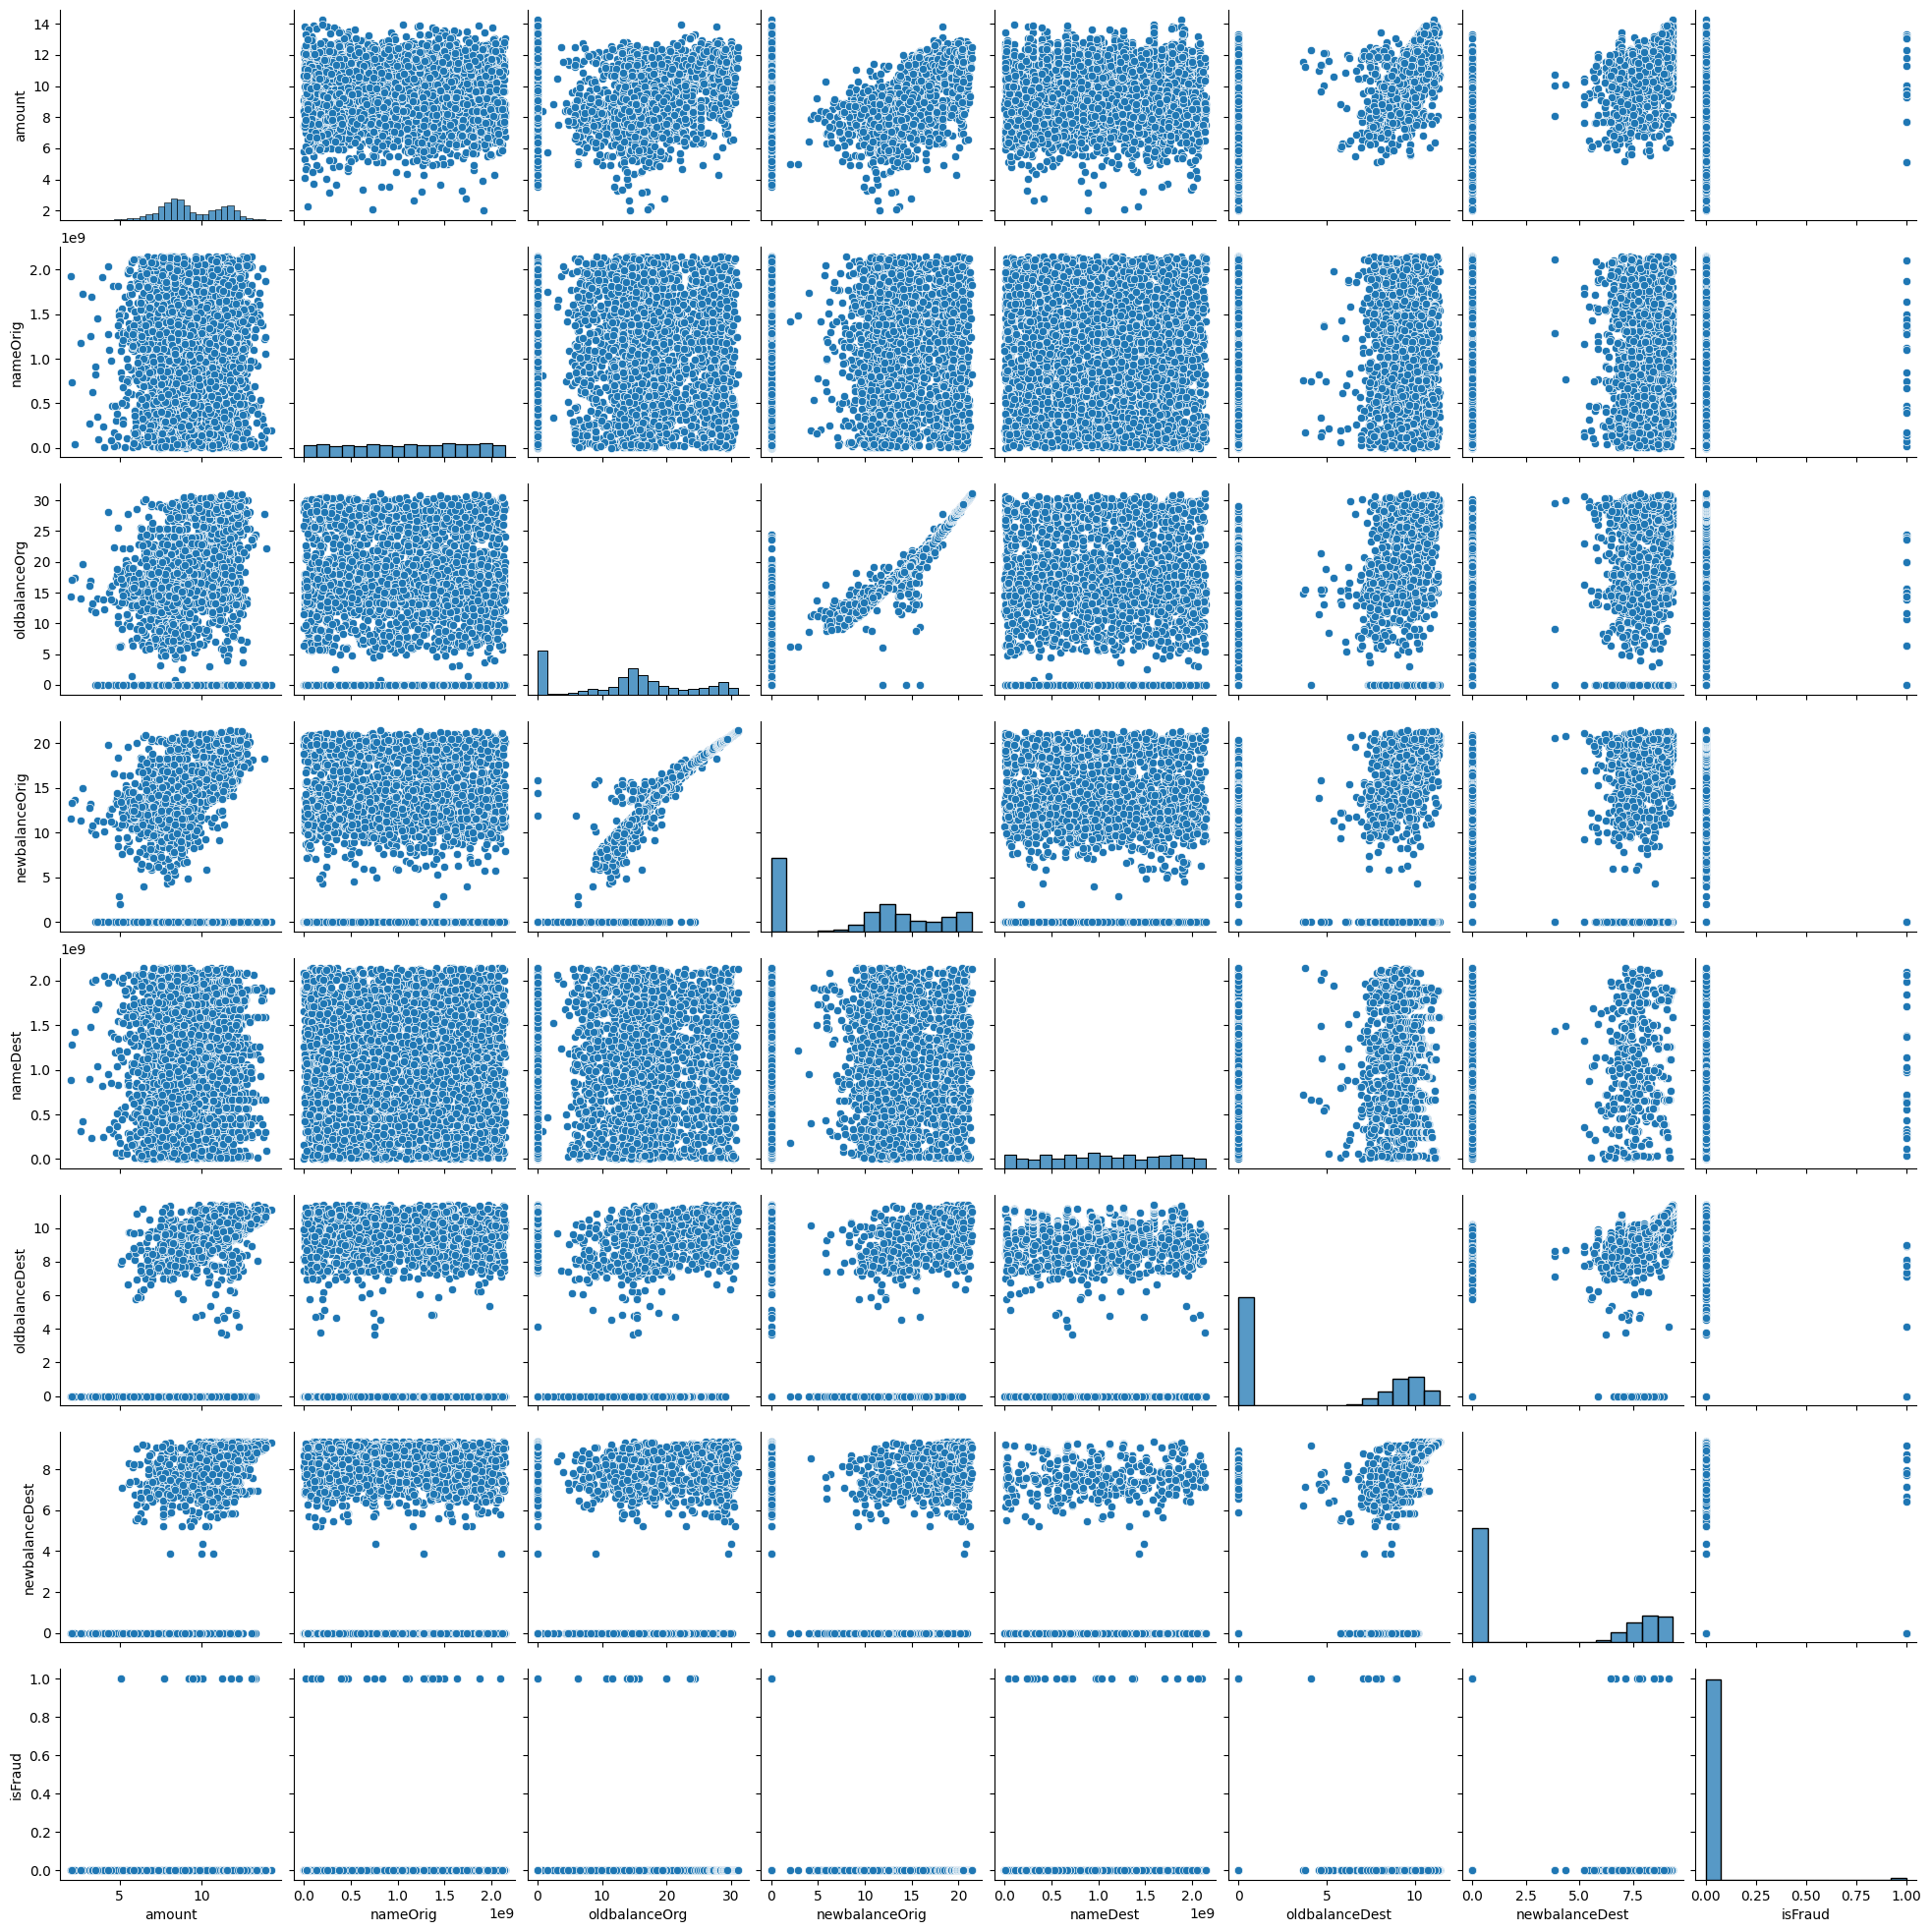

In [35]:
# Plot continuous features against one another and target

continuous_cols = transformed_df.select_dtypes(include=["int", "float"]).iloc[:,1:-1]

pair_plot_cols = pd.concat([continuous_cols, transformed_df["isFraud"]], axis=1)
sns.pairplot(pair_plot_cols)
plt.show()

In [36]:
# Linear relationships indicated between  old and new balance amounts.
# However, no strong discriminatory signals indicated with respect to the target for any range of values. 

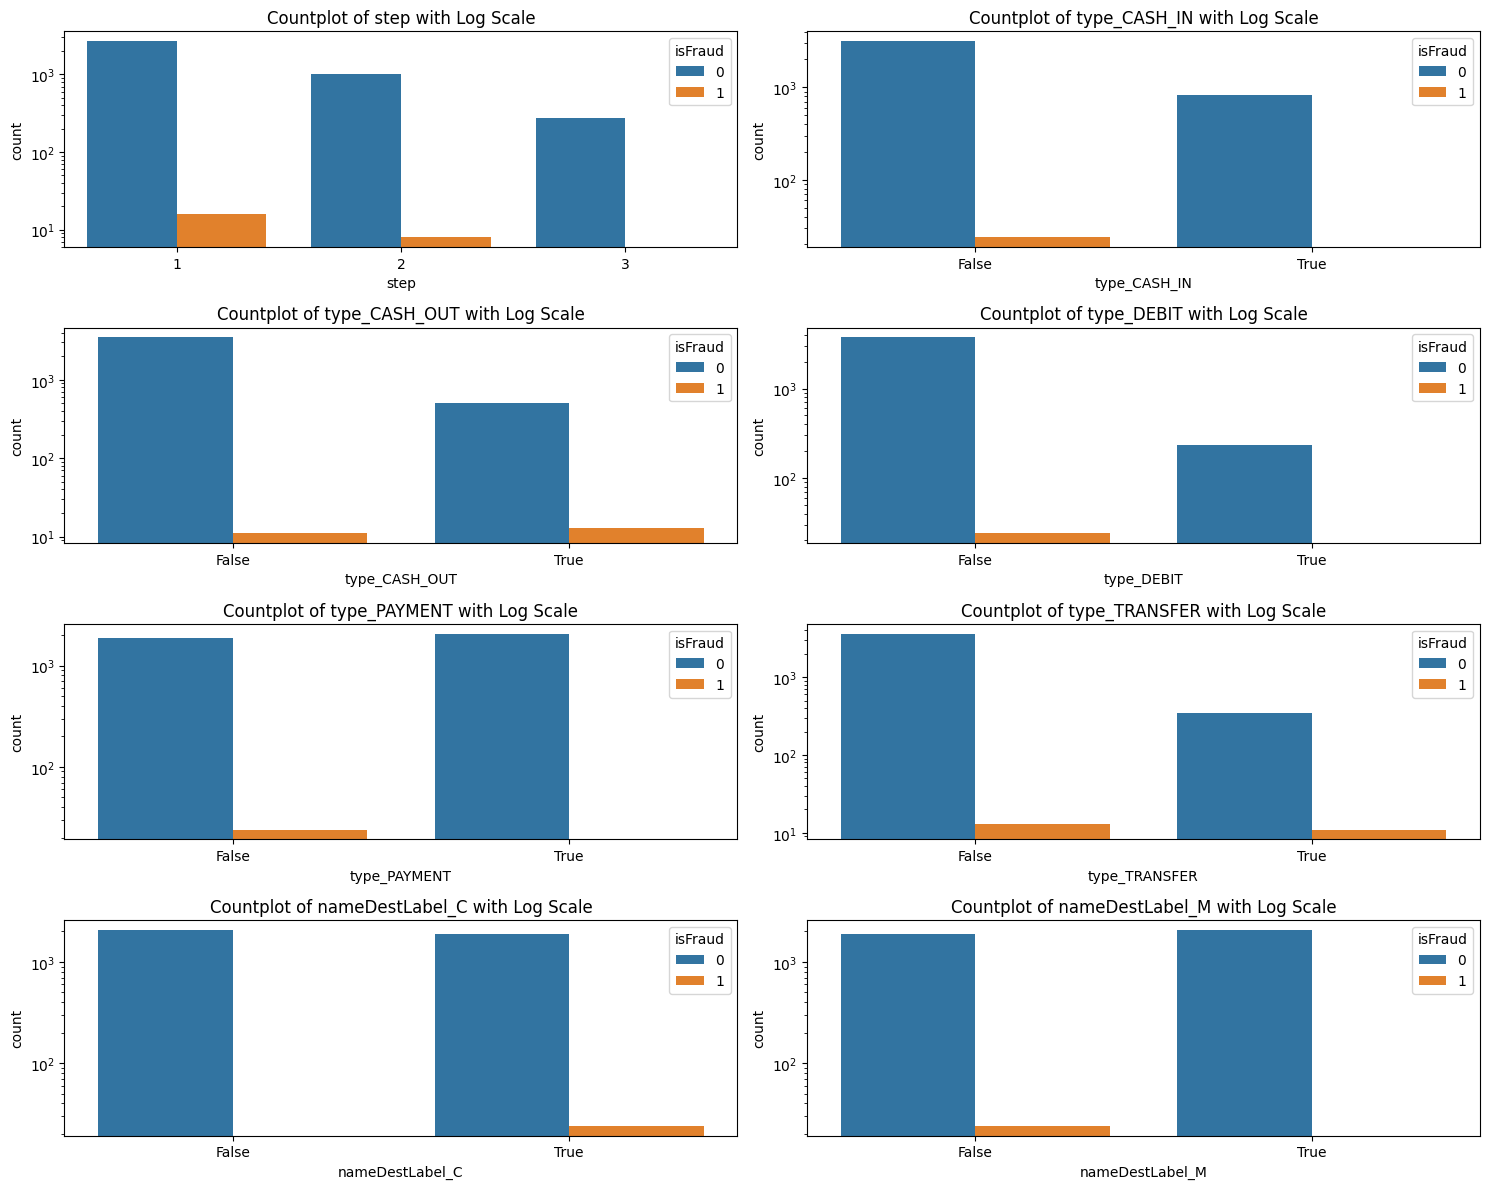

In [37]:
# Visualise relationship between discrete variables and target with log scaling to improve visualisation 
# where count amounts are comparatively very low

n = len(discrete_cols)

fig, ax = plt.subplots(math.ceil(n/2), 2, figsize=(15,12), sharey=False)
axes = ax.flatten()

for i in range(n):
    sns.countplot(data=transformed_df, x=discrete_cols[i], hue=transformed_df["isFraud"], ax=axes[i])    
    axes[i].set_yscale('log')
    axes[i].set_title(f'Countplot of {discrete_cols[i]} with Log Scale')     
    
plt.tight_layout()
plt.show()                 

In [38]:
# Positive instances of 'type_TRANSFER' and 'type_CASH_OUT' possess some occurrence of target as does the destination type being 'customer' and 1hr and 2hr transactions
# However, no discriminatory power revealed for features with respect to target yet.

In [39]:
# Underwhelming discriminatory power in bi-variate analysis may indicate nonlinearities 
# need to be explored along with attempts to feature engineer interactions terms.
# Analysis of subsequent modelling may prove insightful on this last point.   

In [40]:
## Multi-variate analysis

In [119]:
# Continuous variable analysis - Parallel Coordinates Analysis

df_subset = transformed_df[skewed_cols]

df_subset['target'] = transformed_df['isFraud']

plt.figure(figsize=(10, 6))
parallel_coordinates(df_subset, 'target', color=('#FF0000', '#00FF00'))
plt.title('Parallel Coordinates Plot of Variables')
plt.xlabel('Features')
plt.ylabel('Values')
plt.legend()
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_2032\2585269204.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# No discernible clustering

In [102]:
# Continuous variable analysis - t-SNE

tsne = TSNE(n_components=3, random_state=42)

X_tsne = tsne.fit_transform(df_subset)

fig = px.scatter_3d(
    x=X_tsne[:, 0], y=X_tsne[:, 1], z=X_tsne[:, 2],
    color=transformed_df["isFraud"], labels={'color': 'Label'},
    title='t-SNE Visualization (3D)'
)
fig.show()

In [103]:
# Some indication of at least 1 cluster concerning positive instances of the target.
# However, points still somewhat intermingled with majority class suggesting overlap/similarity at this point in space between the 2 target variable classes.
# To attempt a quick DBSCAN to see if can understand any clusters better through their relative densities. 

In [128]:
df_subset.columns

Index(['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest'],
      dtype='object')

In [126]:
from sklearn.cluster import DBSCAN
continuous_features = df_subset.columns

data = df_subset.copy()
data["target"] = transformed_df["isFraud"]

dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(data[continuous_features])

fig = px.scatter_3d(
    data,
    x=continuous_features[0],
    y=continuous_features[1],
    z=continuous_features[2],
    color="target",
    color_continuous_scale="Viridis",
    opacity=0.8
)

# Add layout settings
fig.update_layout(
    scene=dict(
        xaxis_title=continuous_features[0],
        yaxis_title=continuous_features[1],
        zaxis_title=continuous_features[2]
    ),
    title="DBSCAN Clustering"
)

# Show the plot
fig.show()

In [ ]:
# No differentiation between the positive and negative instances of the target.

In [89]:
# Discrete variable analysis - MCA
data = transformed_df[discrete_cols]
data = data.astype(int)
mca = MCA(
    n_components=2,
    n_iter=3,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
)
mca = mca.fit(data)

mca.plot(
    data,
    x_component=0,
    y_component=1
)

alt.Chart(...)

In [78]:
(mca.col_masses_).sort_values(ascending=False)

type_DEBIT_0         0.117750
type_TRANSFER_0      0.113750
type_CASH_OUT_0      0.108969
type_CASH_IN_0       0.099438
step_1               0.084625
nameDestLabel_C_0    0.064906
type_PAYMENT_1       0.064906
nameDestLabel_M_1    0.064906
type_PAYMENT_0       0.060094
nameDestLabel_C_1    0.060094
nameDestLabel_M_0    0.060094
step_2               0.031688
type_CASH_IN_1       0.025563
type_CASH_OUT_1      0.016031
type_TRANSFER_1      0.011250
step_3               0.008688
type_DEBIT_1         0.007250
dtype: float64

In [97]:
mca.row_masses_

0       0.00025
1       0.00025
2       0.00025
3       0.00025
4       0.00025
         ...   
3995    0.00025
3996    0.00025
3997    0.00025
3998    0.00025
3999    0.00025
Length: 4000, dtype: float64

In [98]:
mca.row_masses_.value_counts()

0.00025    4000
Name: count, dtype: int64

In [99]:
# Given homogeneity of row masses this suggests no strong differentiation/clustering among observations based on MCA contribution.

In [100]:
# Given lack of insight from parallel coordinate analysis and MCA approaches will have to look at interaction terms to better tease out underlying patterns/relationships in data.   